In [2]:
import pandas as pd
import numpy as np

def create_time_features(df, order_time_col='order_create_time', session_end_col='session_end_time'):
    """
    Создает новые временные признаки на основе колонок с временными метками.
    
    Параметры:
    df - DataFrame с данными
    order_time_col - название колонки с временем создания заказа (timestamp)
    session_end_col - название колонки с временем окончания сессии (timestamp)
    
    Возвращает:
    DataFrame с добавленными новыми признаками
    """
    # Создаем копию DataFrame чтобы избежать предупреждений
    df = df.copy()
    
    # Преобразуем колонки в datetime, если они еще не в этом формате
    df[order_time_col] = pd.to_datetime(df[order_time_col])
    df[session_end_col] = pd.to_datetime(df[session_end_col])
    
    # 1. Разница между окончанием сессии и созданием заказа (в секундах)
    df['time_to_order_seconds'] = (df[session_end_col] - df[order_time_col]).dt.total_seconds()
    
    # 2. Признаки времени создания заказа
    df['order_hour'] = df[order_time_col].dt.hour
    df['order_day_of_week'] = df[order_time_col].dt.dayofweek  # 0-понедельник, 6-воскресенье
    df['order_day_of_month'] = df[order_time_col].dt.day
    df['order_month'] = df[order_time_col].dt.month
    df['order_week_of_year'] = df[order_time_col].dt.isocalendar().week
    df['order_is_weekend'] = df[order_time_col].dt.dayofweek >= 5
    
    # 3. Признаки времени окончания сессии
    df['session_end_hour'] = df[session_end_col].dt.hour
    df['session_end_day_of_week'] = df[session_end_col].dt.dayofweek
    df['session_end_day_of_month'] = df[session_end_col].dt.day
    df['session_end_month'] = df[session_end_col].dt.month
    df['session_end_week_of_year'] = df[session_end_col].dt.isocalendar().week
    df['session_end_is_weekend'] = df[session_end_col].dt.dayofweek >= 5
    
    # 4. Разница во времени в разных единицах
    df['time_to_order_minutes'] = df['time_to_order_seconds'] / 60
    df['time_to_order_hours'] = df['time_to_order_seconds'] / 3600
    
    # 5. Временные категории (утро/день/вечер/ночь)
    bins = [-1, 6, 12, 18, 23]
    labels = ['night', 'morning', 'afternoon', 'evening']
    df['order_time_of_day'] = pd.cut(df['order_hour'], bins=bins, labels=labels)
    df['session_end_time_of_day'] = pd.cut(df['session_end_hour'], bins=bins, labels=labels)
    
    # 6. Является ли заказ сделан в тот же день, что и сессия
    df['same_day_order'] = df[order_time_col].dt.date == df[session_end_col].dt.date
    
    # 7. Сезонность (времена года)
    def get_season(month):
        if month in [12, 1, 2]:
            return 'winter'
        elif month in [3, 4, 5]:
            return 'spring'
        elif month in [6, 7, 8]:
            return 'summer'
        else:
            return 'autumn'
    
    df['order_season'] = df['order_month'].apply(get_season)
    df['session_end_season'] = df['session_end_month'].apply(get_season)
    
    return df

[LightGBM] [Info] Number of positive: 29679, number of negative: 53997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1563
[LightGBM] [Info] Number of data points in the train set: 83676, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.354690 -> initscore=-0.598489
[LightGBM] [Info] Start training from score -0.598489


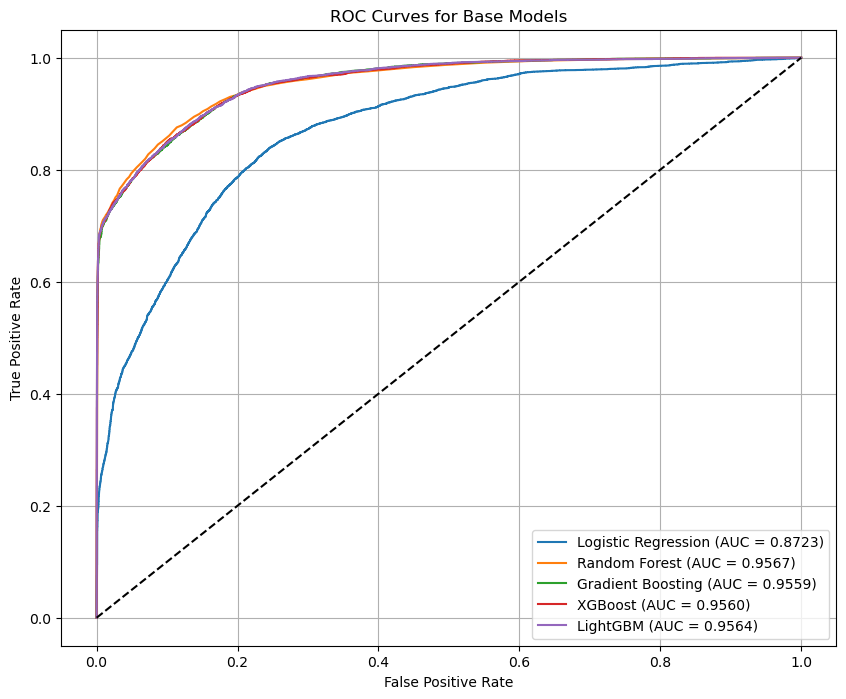

ROC AUC scores:
Logistic Regression: 0.8723
Random Forest: 0.9567
Gradient Boosting: 0.9559
XGBoost: 0.9560
LightGBM: 0.9564


In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Выделим категориальные и числовые признаки
cat_features = tr.select_dtypes(include='object').columns.tolist()
num_features = tr.select_dtypes(include=['number', 'float', 'int']).columns.tolist()

# Препроцессор для признаков
preprocessor = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='mean'), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

# Список моделей с пайплайнами
from sklearn.pipeline import make_pipeline

models = {
    "Logistic Regression": make_pipeline(preprocessor, LogisticRegression(max_iter=1000)),
    "Random Forest": make_pipeline(preprocessor, RandomForestClassifier(n_estimators=100, random_state=42)),
    "Gradient Boosting": make_pipeline(preprocessor, GradientBoostingClassifier(n_estimators=100, random_state=42)),
    "XGBoost": make_pipeline(preprocessor, XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    "LightGBM": make_pipeline(preprocessor, LGBMClassifier(random_state=42))
}

# Разделение на трейн и валидацию
X_train, X_val, y_train, y_val = train_test_split(tr, target, test_size=0.2, random_state=42, stratify=target)

# Хранилище результатов
roc_auc_scores = {}
plt.figure(figsize=(10, 8))

# Обучение и ROC-кривые
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    roc_auc_scores[name] = auc
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')

# График
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Base Models')
plt.legend()
plt.grid()
plt.show()

# Печать
print("ROC AUC scores:")
for name, auc in roc_auc_scores.items():
    print(f"{name}: {auc:.4f}")


Training and stacking: lgbm
[LightGBM] [Info] Number of positive: 19786, number of negative: 35998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1559
[LightGBM] [Info] Number of data points in the train set: 55784, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.354690 -> initscore=-0.598489
[LightGBM] [Info] Start training from score -0.598489


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 1 done for lgbm
[LightGBM] [Info] Number of positive: 19786, number of negative: 35998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1559
[LightGBM] [Info] Number of data points in the train set: 55784, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.354690 -> initscore=-0.598489
[LightGBM] [Info] Start training from score -0.598489


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 2 done for lgbm
[LightGBM] [Info] Number of positive: 19786, number of negative: 35998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1560
[LightGBM] [Info] Number of data points in the train set: 55784, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.354690 -> initscore=-0.598489
[LightGBM] [Info] Start training from score -0.598489


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 3 done for lgbm
[LightGBM] [Info] Number of positive: 29679, number of negative: 53997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1563
[LightGBM] [Info] Number of data points in the train set: 83676, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.354690 -> initscore=-0.598489
[LightGBM] [Info] Start training from score -0.598489


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Completed stacking for: lgbm

Training and stacking: svm_rbf
  Fold 1 done for svm_rbf
  Fold 2 done for svm_rbf
  Fold 3 done for svm_rbf
Completed stacking for: svm_rbf

Training and stacking: knn_5
  Fold 1 done for knn_5
  Fold 2 done for knn_5
  Fold 3 done for knn_5
Completed stacking for: knn_5

Training and stacking: knn_15
  Fold 1 done for knn_15
  Fold 2 done for knn_15
  Fold 3 done for knn_15
Completed stacking for: knn_15

Training meta-model Logistic Regression
Meta-model ROC AUC: 0.9556


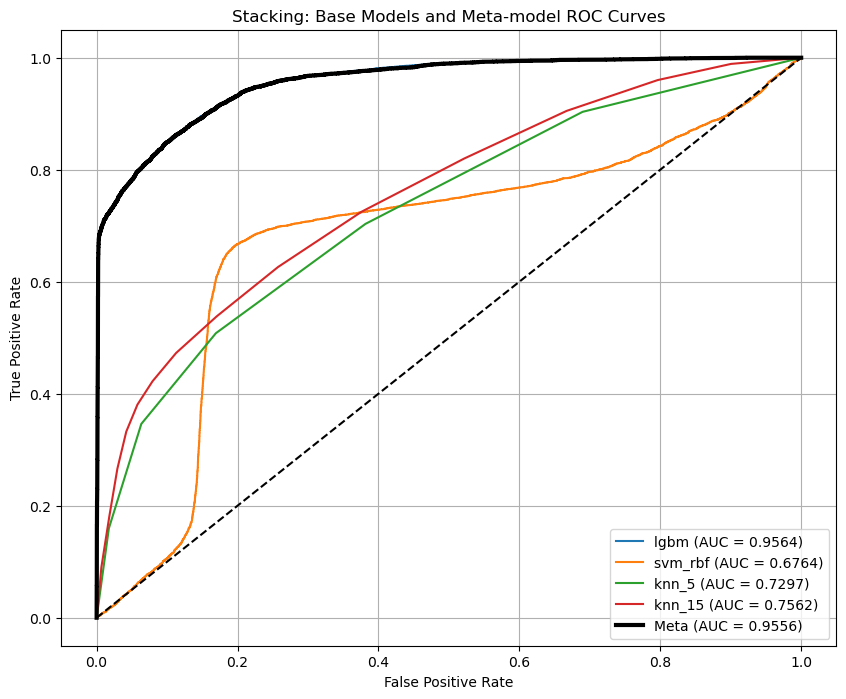

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Модели
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LogisticRegression

# Загрузка данных
tr = pd.read_parquet('data/train.parquet')
target = tr.target
tr = tr.drop(columns='target')

# Создание фич (предполагаем, что функция create_time_features объявлена)
tr = create_time_features(tr)
tr = tr.drop(columns=['order_create_time', 'session_end_time'])

# Выделим категориальные и числовые признаки
cat_features = tr.select_dtypes(include='object').columns.tolist()
num_features = tr.select_dtypes(include=['number', 'float', 'int']).columns.tolist()

# Препроцессор
preprocessor = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='mean'), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

# Базовые модели для стекинга
base_models = {
    'lgbm': make_pipeline(preprocessor, LGBMClassifier(random_state=42)),
    'svm_rbf': make_pipeline(preprocessor, SVC(kernel='rbf', probability=True, random_state=42)),
    'knn_5': make_pipeline(preprocessor, KNeighborsClassifier(n_neighbors=5)),
    'knn_15': make_pipeline(preprocessor, KNeighborsClassifier(n_neighbors=15)),
    #'kernel_ridge': make_pipeline(preprocessor, KernelRidge(kernel='rbf', alpha=1.0))
}

# Сплит на трейн и валидацию
X_train, X_val, y_train, y_val = train_test_split(
    tr, target, test_size=0.2, random_state=42, stratify=target
)

# Стековые фичи
n_train = X_train.shape[0]
stacked_train = np.zeros((n_train, len(base_models)))
stacked_val = np.zeros((X_val.shape[0], len(base_models)))

# KFold для OOF-предсказаний
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for idx, (name, model) in enumerate(base_models.items()):
    print(f"Training and stacking: {name}")
    oof = np.zeros(n_train)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_va = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        model.fit(X_tr, y_tr)
        # Для KernelRidge используем predict, у остальных predict_proba
        if hasattr(model, 'predict_proba'):
            oof[valid_idx] = model.predict_proba(X_va)[:, 1]
        else:
            oof[valid_idx] = model.predict(X_va)
        print(f"  Fold {fold+1} done for {name}")
    # Обучаем на всю X_train для предсказания валидации
    model.fit(X_train, y_train)
    if hasattr(model, 'predict_proba'):
        stacked_val[:, idx] = model.predict_proba(X_val)[:, 1]
    else:
        stacked_val[:, idx] = model.predict(X_val)
    stacked_train[:, idx] = oof
    print(f"Completed stacking for: {name}\n")

# Мета-модель
meta_model = LogisticRegression(max_iter=1000)
print("Training meta-model Logistic Regression")
meta_model.fit(stacked_train, y_train)

# Предсказание на валидации
meta_pred = meta_model.predict_proba(stacked_val)[:, 1]
meta_auc = roc_auc_score(y_val, meta_pred)
print(f"Meta-model ROC AUC: {meta_auc:.4f}")

# ROC-кривые всех базовых и мета-модели
plt.figure(figsize=(10, 8))
for idx, (name, _) in enumerate(base_models.items()):
    fpr, tpr, _ = roc_curve(y_val, stacked_val[:, idx])
    auc = roc_auc_score(y_val, stacked_val[:, idx])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')
fpr, tpr, _ = roc_curve(y_val, meta_pred)
plt.plot(fpr, tpr, label=f'Meta (AUC = {meta_auc:.4f})', linewidth=3, color='black')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stacking: Base Models and Meta-model ROC Curves')
plt.legend()
plt.grid()
plt.show()

Training meta-model LGBM
[LightGBM] [Info] Number of positive: 29679, number of negative: 53997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 532
[LightGBM] [Info] Number of data points in the train set: 83676, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.354690 -> initscore=-0.598489
[LightGBM] [Info] Start training from score -0.598489
Meta-model ROC AUC: 0.9559


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


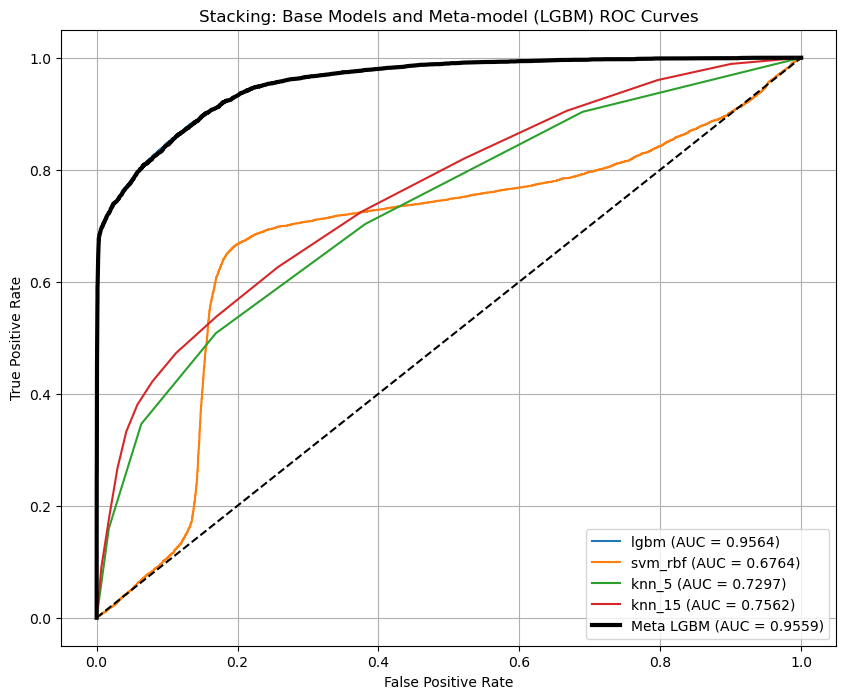

In [5]:
# Мета-модель (LGBM вместо LogisticRegression)
meta_model = LGBMClassifier(random_state=42)
print("Training meta-model LGBM")
meta_model.fit(stacked_train, y_train)

# Предсказание на валидации
meta_pred = meta_model.predict_proba(stacked_val)[:, 1]
meta_auc = roc_auc_score(y_val, meta_pred)
print(f"Meta-model ROC AUC: {meta_auc:.4f}")

# ROC-кривые всех базовых и мета-модели
plt.figure(figsize=(10, 8))
for idx, (name, _) in enumerate(base_models.items()):
    fpr, tpr, _ = roc_curve(y_val, stacked_val[:, idx])
    auc = roc_auc_score(y_val, stacked_val[:, idx])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')
fpr, tpr, _ = roc_curve(y_val, meta_pred)
plt.plot(fpr, tpr, label=f'Meta LGBM (AUC = {meta_auc:.4f})', linewidth=3, color='black')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stacking: Base Models and Meta-model (LGBM) ROC Curves')
plt.legend()
plt.grid()
plt.show()

Meta-model ROC AUC: 0.9560


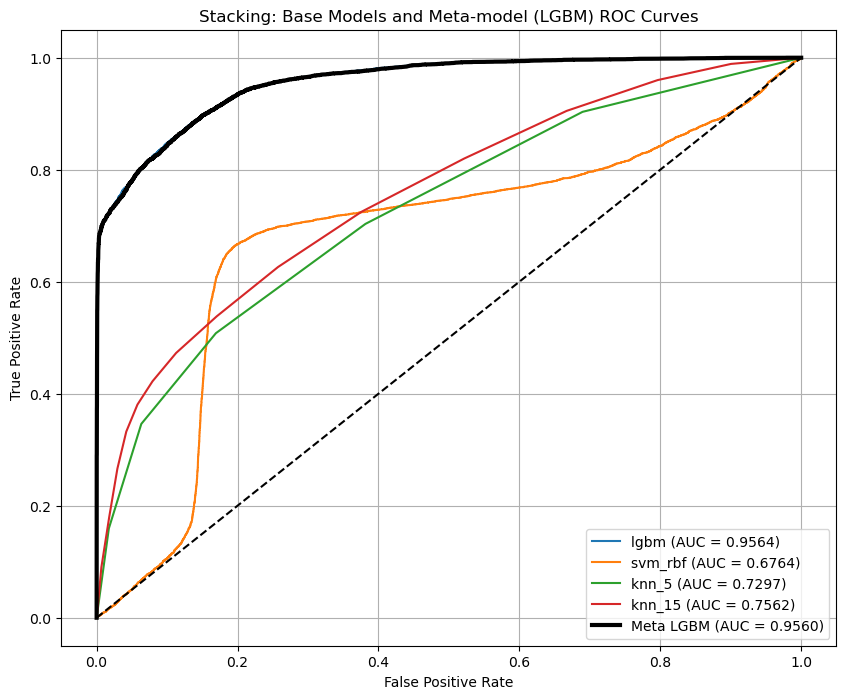

In [6]:
from catboost import CatBoostClassifier

meta_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    random_seed=42,
    verbose=0
)
meta_model.fit(stacked_train, y_train)

# Предсказание на валидации
meta_pred = meta_model.predict_proba(stacked_val)[:, 1]
meta_auc = roc_auc_score(y_val, meta_pred)
print(f"Meta-model ROC AUC: {meta_auc:.4f}")

# ROC-кривые всех базовых и мета-модели
plt.figure(figsize=(10, 8))
for idx, (name, _) in enumerate(base_models.items()):
    fpr, tpr, _ = roc_curve(y_val, stacked_val[:, idx])
    auc = roc_auc_score(y_val, stacked_val[:, idx])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')
fpr, tpr, _ = roc_curve(y_val, meta_pred)
plt.plot(fpr, tpr, label=f'Meta LGBM (AUC = {meta_auc:.4f})', linewidth=3, color='black')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stacking: Base Models and Meta-model (LGBM) ROC Curves')
plt.legend()
plt.grid()
plt.show()

c:\Users\Admin\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:17:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Meta-model ROC AUC: 0.9556


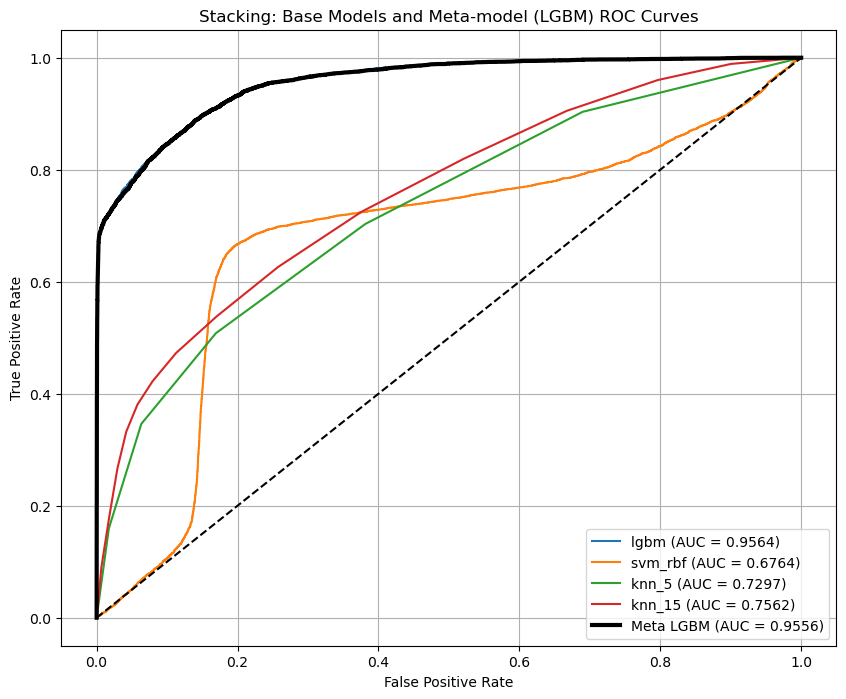

In [7]:
from xgboost import XGBClassifier

meta_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
meta_model.fit(stacked_train, y_train)

# Предсказание на валидации
meta_pred = meta_model.predict_proba(stacked_val)[:, 1]
meta_auc = roc_auc_score(y_val, meta_pred)
print(f"Meta-model ROC AUC: {meta_auc:.4f}")

# ROC-кривые всех базовых и мета-модели
plt.figure(figsize=(10, 8))
for idx, (name, _) in enumerate(base_models.items()):
    fpr, tpr, _ = roc_curve(y_val, stacked_val[:, idx])
    auc = roc_auc_score(y_val, stacked_val[:, idx])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')
fpr, tpr, _ = roc_curve(y_val, meta_pred)
plt.plot(fpr, tpr, label=f'Meta LGBM (AUC = {meta_auc:.4f})', linewidth=3, color='black')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stacking: Base Models and Meta-model (LGBM) ROC Curves')
plt.legend()
plt.grid()
plt.show()

Meta-model ROC AUC: 0.9560


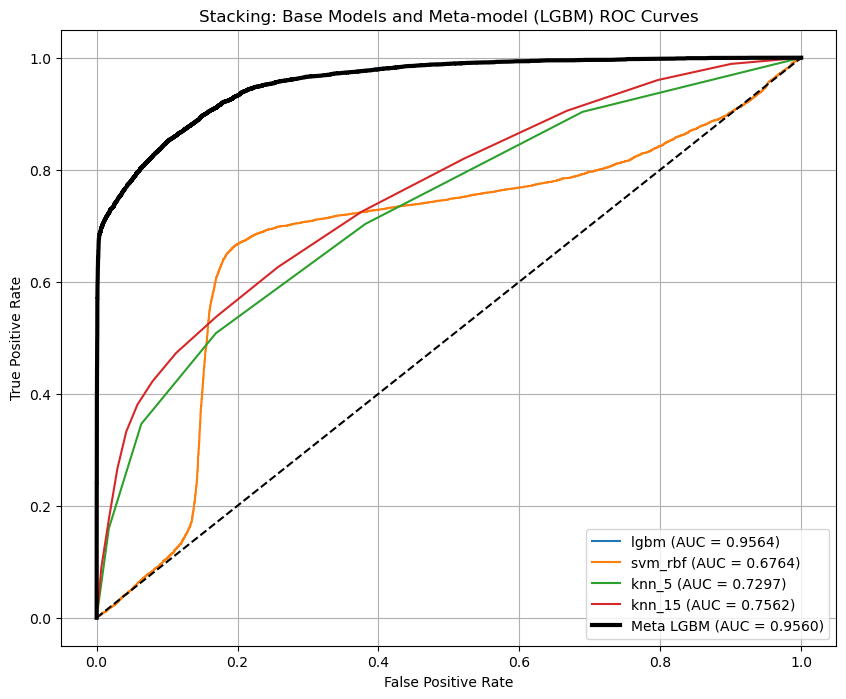

In [8]:
from sklearn.ensemble import RandomForestClassifier

meta_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
meta_model.fit(stacked_train, y_train)

# Предсказание на валидации
meta_pred = meta_model.predict_proba(stacked_val)[:, 1]
meta_auc = roc_auc_score(y_val, meta_pred)
print(f"Meta-model ROC AUC: {meta_auc:.4f}")

# ROC-кривые всех базовых и мета-модели
plt.figure(figsize=(10, 8))
for idx, (name, _) in enumerate(base_models.items()):
    fpr, tpr, _ = roc_curve(y_val, stacked_val[:, idx])
    auc = roc_auc_score(y_val, stacked_val[:, idx])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')
fpr, tpr, _ = roc_curve(y_val, meta_pred)
plt.plot(fpr, tpr, label=f'Meta LGBM (AUC = {meta_auc:.4f})', linewidth=3, color='black')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stacking: Base Models and Meta-model (LGBM) ROC Curves')
plt.legend()
plt.grid()
plt.show()

Meta-model ROC AUC: 0.9563


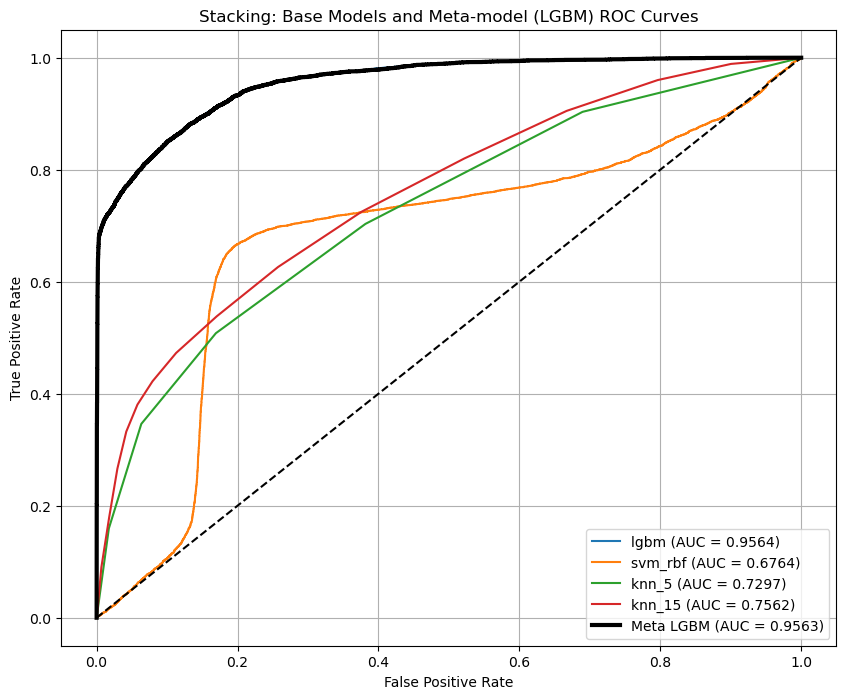

In [9]:
from sklearn.neural_network import MLPClassifier

meta_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=300,
    random_state=42,
    early_stopping=True
)
meta_model.fit(stacked_train, y_train)

# Предсказание на валидации
meta_pred = meta_model.predict_proba(stacked_val)[:, 1]
meta_auc = roc_auc_score(y_val, meta_pred)
print(f"Meta-model ROC AUC: {meta_auc:.4f}")

# ROC-кривые всех базовых и мета-модели
plt.figure(figsize=(10, 8))
for idx, (name, _) in enumerate(base_models.items()):
    fpr, tpr, _ = roc_curve(y_val, stacked_val[:, idx])
    auc = roc_auc_score(y_val, stacked_val[:, idx])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')
fpr, tpr, _ = roc_curve(y_val, meta_pred)
plt.plot(fpr, tpr, label=f'Meta LGBM (AUC = {meta_auc:.4f})', linewidth=3, color='black')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stacking: Base Models and Meta-model (LGBM) ROC Curves')
plt.legend()
plt.grid()
plt.show()

Meta-model ROC AUC: 0.9563


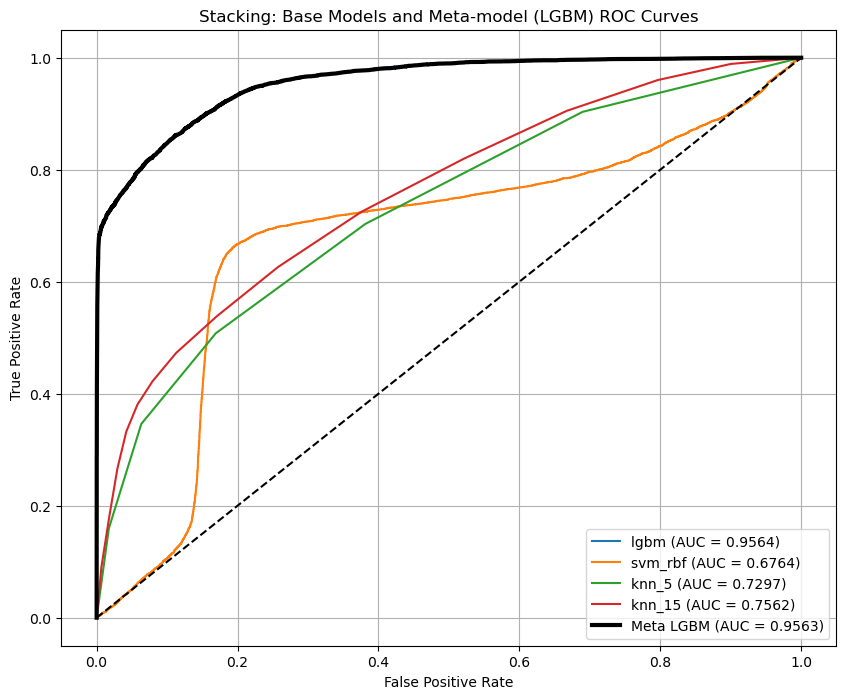

In [10]:
from sklearn.ensemble import GradientBoostingClassifier

meta_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    random_state=42
)
meta_model.fit(stacked_train, y_train)

# Предсказание на валидации
meta_pred = meta_model.predict_proba(stacked_val)[:, 1]
meta_auc = roc_auc_score(y_val, meta_pred)
print(f"Meta-model ROC AUC: {meta_auc:.4f}")

# ROC-кривые всех базовых и мета-модели
plt.figure(figsize=(10, 8))
for idx, (name, _) in enumerate(base_models.items()):
    fpr, tpr, _ = roc_curve(y_val, stacked_val[:, idx])
    auc = roc_auc_score(y_val, stacked_val[:, idx])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')
fpr, tpr, _ = roc_curve(y_val, meta_pred)
plt.plot(fpr, tpr, label=f'Meta LGBM (AUC = {meta_auc:.4f})', linewidth=3, color='black')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stacking: Base Models and Meta-model (LGBM) ROC Curves')
plt.legend()
plt.grid()
plt.show()

Meta-model ROC AUC: 0.9553


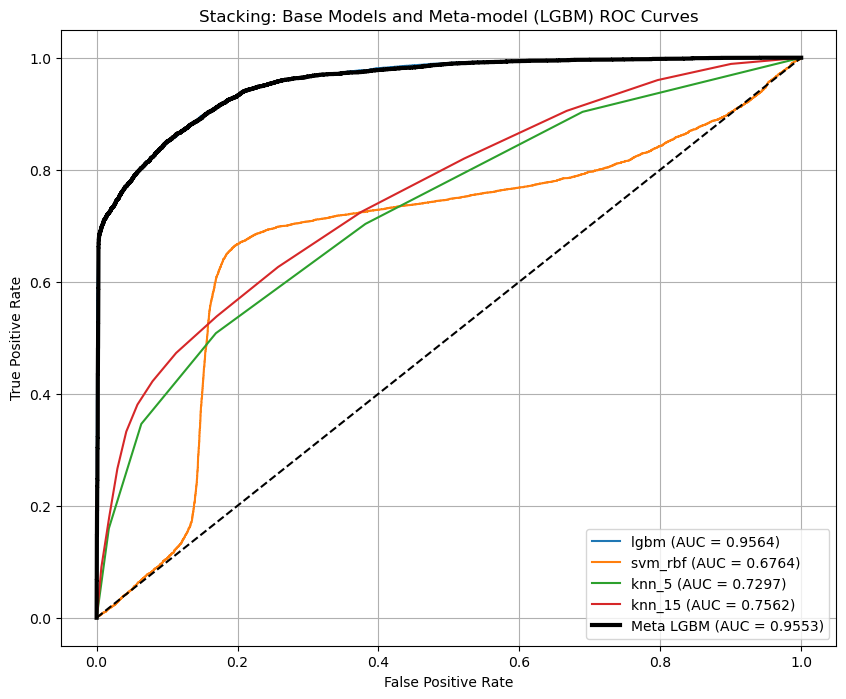

In [11]:
from sklearn.linear_model import SGDClassifier

meta_model = SGDClassifier(
    loss='log_loss',
    penalty='elasticnet',
    alpha=0.001,
    l1_ratio=0.5,
    max_iter=1000,
    random_state=42,
    learning_rate='optimal'
)
meta_model.fit(stacked_train, y_train)

# Предсказание на валидации
meta_pred = meta_model.predict_proba(stacked_val)[:, 1]
meta_auc = roc_auc_score(y_val, meta_pred)
print(f"Meta-model ROC AUC: {meta_auc:.4f}")

# ROC-кривые всех базовых и мета-модели
plt.figure(figsize=(10, 8))
for idx, (name, _) in enumerate(base_models.items()):
    fpr, tpr, _ = roc_curve(y_val, stacked_val[:, idx])
    auc = roc_auc_score(y_val, stacked_val[:, idx])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')
fpr, tpr, _ = roc_curve(y_val, meta_pred)
plt.plot(fpr, tpr, label=f'Meta LGBM (AUC = {meta_auc:.4f})', linewidth=3, color='black')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stacking: Base Models and Meta-model (LGBM) ROC Curves')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.linear_model import SGDClassifier

meta_model = SGDClassifier(
    loss='log_loss',
    penalty='elasticnet',
    alpha=0.001,
    l1_ratio=0.5,
    max_iter=1000,
    random_state=42,
    learning_rate='optimal'
)
meta_model.fit(stacked_train, y_train)

# Предсказание на валидации
meta_pred = meta_model.predict_proba(stacked_val)[:, 1]
meta_auc = roc_auc_score(y_val, meta_pred)
print(f"Meta-model ROC AUC: {meta_auc:.4f}")

# ROC-кривые всех базовых и мета-модели
plt.figure(figsize=(10, 8))
for idx, (name, _) in enumerate(base_models.items()):
    fpr, tpr, _ = roc_curve(y_val, stacked_val[:, idx])
    auc = roc_auc_score(y_val, stacked_val[:, idx])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')
fpr, tpr, _ = roc_curve(y_val, meta_pred)
plt.plot(fpr, tpr, label=f'Meta LGBM (AUC = {meta_auc:.4f})', linewidth=3, color='black')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stacking: Base Models and Meta-model (LGBM) ROC Curves')
plt.legend()
plt.grid()
plt.show()

Meta-model ROC AUC: 0.9560


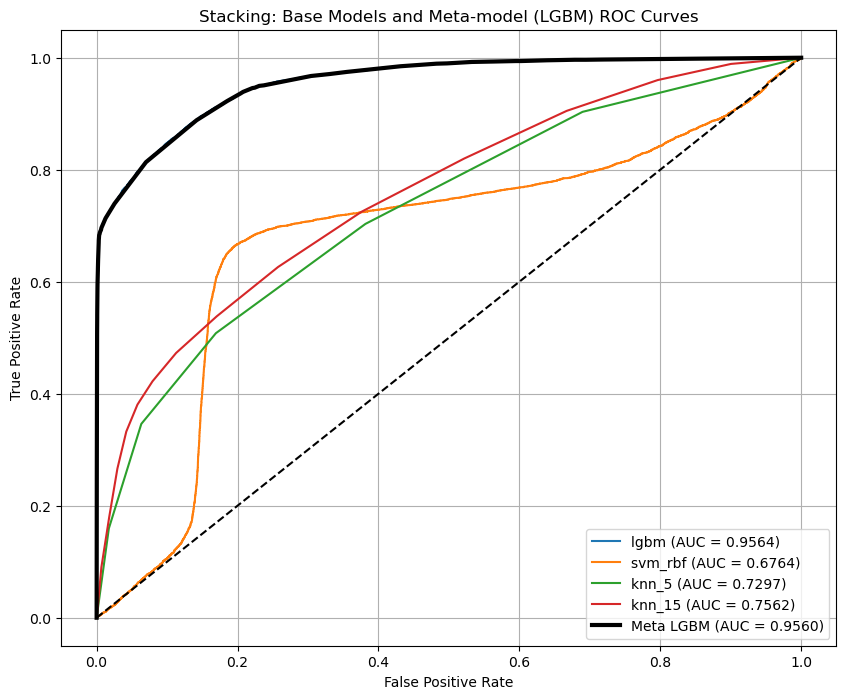

In [12]:
from sklearn.ensemble import AdaBoostClassifier

meta_model = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)
meta_model.fit(stacked_train, y_train)

# Предсказание на валидации
meta_pred = meta_model.predict_proba(stacked_val)[:, 1]
meta_auc = roc_auc_score(y_val, meta_pred)
print(f"Meta-model ROC AUC: {meta_auc:.4f}")

# ROC-кривые всех базовых и мета-модели
plt.figure(figsize=(10, 8))
for idx, (name, _) in enumerate(base_models.items()):
    fpr, tpr, _ = roc_curve(y_val, stacked_val[:, idx])
    auc = roc_auc_score(y_val, stacked_val[:, idx])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')
fpr, tpr, _ = roc_curve(y_val, meta_pred)
plt.plot(fpr, tpr, label=f'Meta LGBM (AUC = {meta_auc:.4f})', linewidth=3, color='black')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stacking: Base Models and Meta-model (LGBM) ROC Curves')
plt.legend()
plt.grid()
plt.show()

Meta-model ROC AUC: 0.9558


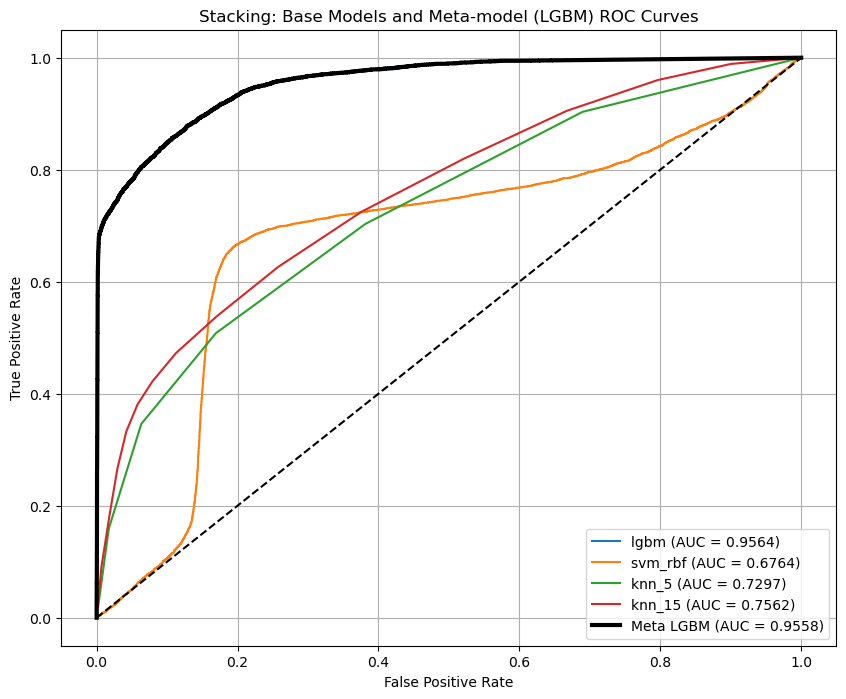

In [17]:
from sklearn.linear_model import SGDClassifier

meta_model = SGDClassifier(
    loss='modified_huber',
    penalty='l2',
    alpha=0.001,
    max_iter=1000,
    random_state=42
)
meta_model.fit(stacked_train, y_train)

# Предсказание на валидации
meta_pred = meta_model.predict_proba(stacked_val)[:, 1]
meta_auc = roc_auc_score(y_val, meta_pred)
print(f"Meta-model ROC AUC: {meta_auc:.4f}")

# ROC-кривые всех базовых и мета-модели
plt.figure(figsize=(10, 8))
for idx, (name, _) in enumerate(base_models.items()):
    fpr, tpr, _ = roc_curve(y_val, stacked_val[:, idx])
    auc = roc_auc_score(y_val, stacked_val[:, idx])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')
fpr, tpr, _ = roc_curve(y_val, meta_pred)
plt.plot(fpr, tpr, label=f'Meta LGBM (AUC = {meta_auc:.4f})', linewidth=3, color='black')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stacking: Base Models and Meta-model (LGBM) ROC Curves')
plt.legend()
plt.grid()
plt.show()

Meta-model ROC AUC: 0.9528


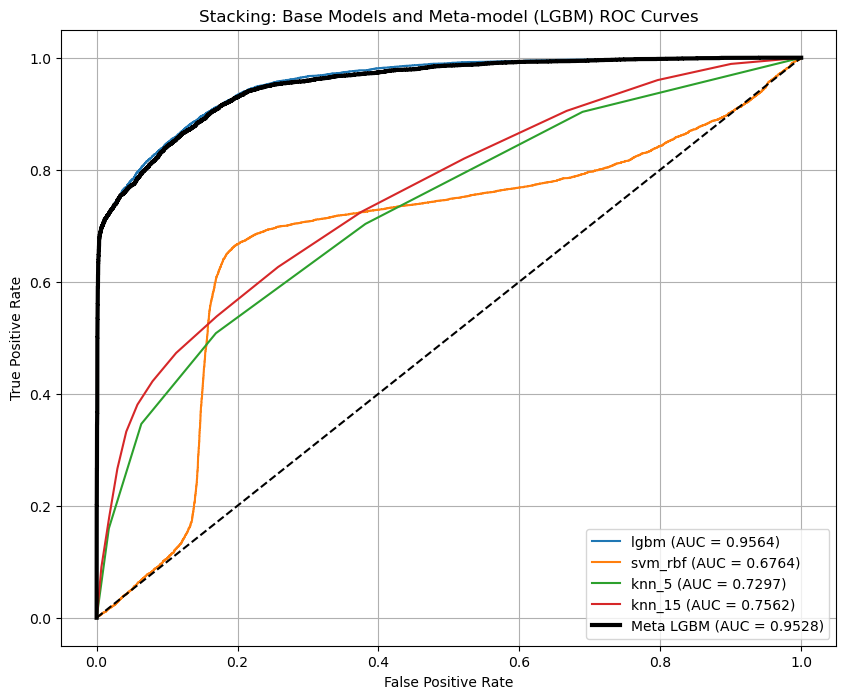

In [18]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

meta_model = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000)),
        ('rf', RandomForestClassifier(n_estimators=100)),
        ('svc', SVC(probability=True))
    ],
    voting='soft'
)
meta_model.fit(stacked_train, y_train)

# Предсказание на валидации
meta_pred = meta_model.predict_proba(stacked_val)[:, 1]
meta_auc = roc_auc_score(y_val, meta_pred)
print(f"Meta-model ROC AUC: {meta_auc:.4f}")

# ROC-кривые всех базовых и мета-модели
plt.figure(figsize=(10, 8))
for idx, (name, _) in enumerate(base_models.items()):
    fpr, tpr, _ = roc_curve(y_val, stacked_val[:, idx])
    auc = roc_auc_score(y_val, stacked_val[:, idx])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')
fpr, tpr, _ = roc_curve(y_val, meta_pred)
plt.plot(fpr, tpr, label=f'Meta LGBM (AUC = {meta_auc:.4f})', linewidth=3, color='black')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stacking: Base Models and Meta-model (LGBM) ROC Curves')
plt.legend()
plt.grid()
plt.show()